In [17]:
from data_preparation_functions import *
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)

## Data prep for ML

In [18]:
# This table includes all of our data in one big DataFrame
df = create_df('data/epl_data.csv')
df.head(3)

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,BWA,BWD,BWH,Bb1X2,BbAH,BbAHh,BbAv<2.5,BbAv>2.5,BbAvA,BbAvAHA,BbAvAHH,BbAvD,BbAvH,BbMx<2.5,BbMx>2.5,BbMxA,BbMxAHA,BbMxAHH,BbMxD,BbMxH,BbOU,Date,Day,Div,FTAG,FTHG,FTR,HC,HF,HR,HS,HST,HTAG,HTHG,HTR,HY,HomeTeam,IWA,IWD,IWH,LBA,LBD,LBH,Month,Referee,VCA,VCD,VCH,Year,season,gameId,homeWin,awayWin,result
0,6.0,14.0,1.0,11.0,5.0,1.0,Blackburn,2.75,3.20,2.5,2.90,3.30,2.20,55.0,20.0,0.00,1.71,2.02,2.74,2.04,1.82,3.16,2.40,1.80,2.25,2.9,2.08,1.86,3.35,2.60,35.0,2005-08-13,13,E0,1.0,3.0,H,2.0,11.0,0.0,13.0,5.0,1.0,0.0,A,0.0,West Ham,2.7,3.0,2.3,2.75,3.0,2.38,8,A Wiley,2.75,3.25,2.4,2005,0506,1,1,0,home
1,8.0,16.0,0.0,13.0,6.0,2.0,Bolton,3.00,3.25,2.3,3.15,3.25,2.10,56.0,22.0,-0.25,1.70,2.01,3.05,1.84,2.01,3.16,2.20,1.87,2.20,3.4,1.92,2.10,3.30,2.40,36.0,2005-08-13,13,E0,2.0,2.0,D,7.0,14.0,0.0,3.0,2.0,2.0,2.0,D,0.0,Aston Villa,3.1,3.0,2.1,3.20,3.0,2.10,8,M Riley,3.10,3.25,2.2,2005,0506,2,0,0,draw
2,6.0,14.0,0.0,12.0,5.0,1.0,Man United,1.72,3.40,5.0,1.75,3.35,4.35,56.0,23.0,0.75,1.79,1.93,1.69,1.86,2.00,3.36,4.69,1.87,2.10,1.8,1.93,2.05,3.70,5.65,36.0,2005-08-13,13,E0,2.0,0.0,A,8.0,15.0,0.0,10.0,5.0,1.0,0.0,A,3.0,Everton,1.8,3.1,3.8,1.83,3.2,3.75,8,G Poll,1.80,3.30,4.5,2005,0506,3,0,1,away


In [19]:
# This includes only the typical soccer stats, like home corners, home shots on target etc.
stats = create_stats_df('data/epl_data.csv')
stats.head(3)

,gameId,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,1,West Ham,Blackburn,3.0,1.0,0.0,1.0,13.0,11.0,5.0,5.0,11.0,14.0,2.0,6.0,0.0,1.0,0.0,1.0
1,2,Aston Villa,Bolton,2.0,2.0,2.0,2.0,3.0,13.0,2.0,6.0,14.0,16.0,7.0,8.0,0.0,2.0,0.0,0.0
2,3,Everton,Man United,0.0,2.0,0.0,1.0,10.0,12.0,5.0,5.0,15.0,14.0,8.0,6.0,3.0,1.0,0.0,0.0


In [20]:
# This includes all of our betting related data, such as win/draw/lose odds, asian handicaps etc.
betting = create_betting_df('data/epl_data.csv')
betting.head(3)

,B365A,B365D,B365H,BWA,BWD,BWH,Bb1X2,BbAH,BbAHh,BbAv<2.5,BbAv>2.5,BbAvA,BbAvAHA,BbAvAHH,BbAvD,BbAvH,BbMx<2.5,BbMx>2.5,BbMxA,BbMxAHA,BbMxAHH,BbMxD,BbMxH,BbOU,Day,Div,IWA,IWD,IWH,LBA,LBD,LBH,Month,VCA,VCD,VCH,Year,homeWin,awayWin,result,HomeTeam,AwayTeam,gameId
0,2.75,3.20,2.5,2.90,3.30,2.20,55.0,20.0,0.00,1.71,2.02,2.74,2.04,1.82,3.16,2.40,1.80,2.25,2.9,2.08,1.86,3.35,2.60,35.0,13,E0,2.7,3.0,2.3,2.75,3.0,2.38,8,2.75,3.25,2.4,2005,1,0,home,West Ham,Blackburn,1
1,3.00,3.25,2.3,3.15,3.25,2.10,56.0,22.0,-0.25,1.70,2.01,3.05,1.84,2.01,3.16,2.20,1.87,2.20,3.4,1.92,2.10,3.30,2.40,36.0,13,E0,3.1,3.0,2.1,3.20,3.0,2.10,8,3.10,3.25,2.2,2005,0,0,draw,Aston Villa,Bolton,2
2,1.72,3.40,5.0,1.75,3.35,4.35,56.0,23.0,0.75,1.79,1.93,1.69,1.86,2.00,3.36,4.69,1.87,2.10,1.8,1.93,2.05,3.70,5.65,36.0,13,E0,1.8,3.1,3.8,1.83,3.2,3.75,8,1.80,3.30,4.5,2005,0,1,away,Everton,Man United,3


In [21]:
# This includes all of the team information for each game.
team_info = create_team_info_df('data/epl_data.csv')
team_info.head(3)

,gameId,Date,season,HomeTeam,AwayTeam,FTR,HTR,Referee
0,1,2005-08-13,0506,West Ham,Blackburn,H,A,A Wiley
1,2,2005-08-13,0506,Aston Villa,Bolton,D,D,M Riley
2,3,2005-08-13,0506,Everton,Man United,A,A,G Poll


In [22]:
# Whilst the other DataFrames date back to 2005, this DataFrame has data from 2001 to 2005.
historic_games = create_historic_games_df('data/historic_games_pre2005.csv')
historic_games.head(3)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,gameId,season,homeWin
0,2001-08-18,Charlton,Everton,1,2,-1,20012002,0
1,2001-08-18,Derby,Blackburn,2,1,-1,20012002,1
2,2001-08-18,Leeds,Southampton,2,0,-1,20012002,1


In [23]:
# This is the historic_games DataFrame appended to the df DataFrame.
all_games = create_all_games_df('data/epl_data.csv', 'data/historic_games_pre2005.csv')
all_games.head(3)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,gameId,season,homeWin,awayWin,homeWinPc5,homeWinPc38,awayWinPc5,awayWinPc38,gameIdHistoric
0,2001-08-18,Charlton,Everton,1.0,2.0,-1,20012002,0,1,NaN,NaN,NaN,NaN,1
1,2001-08-18,Derby,Blackburn,2.0,1.0,-1,20012002,1,0,NaN,NaN,NaN,NaN,2
2,2001-08-18,Leeds,Southampton,2.0,0.0,-1,20012002,1,0,NaN,NaN,NaN,NaN,3


## Moar features

In [24]:
# Define a function which restructures our DataFrame
def create_multiline_df_stats(old_stats_df):
    # Create a list of columns we want and their mappings to more interpretable names
    home_stats_cols = ['HomeTeam', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY',
                       'HR', 'AR']

    away_stats_cols = ['AwayTeam', 'FTAG', 'FTHG', 'HTAG', 'HTHG', 'AS', 'HS', 'AST', 'HST', 'AF', 'HF', 'AC', 'HC', 'AY', 'HY',
                       'AR', 'HR']

    stats_cols_mapping = ['team', 'goalsFor', 'goalsAgainst', 'halfTimeGoalsFor', 'halfTimeGoalsAgainst', 'shotsFor',
                          'shotsAgainst', 'shotsOnTargetFor', 'shotsOnTargetAgainst', 'freesFor', 'freesAgainst', 
                          'cornersFor', 'cornersAgainst', 'yellowsFor', 'yellowsAgainst', 'redsFor', 'redsAgainst']

    # Create a dictionary of the old column names to new column names
    home_mapping = {old_col: new_col for old_col, new_col in zip(home_stats_cols, stats_cols_mapping)}
    away_mapping = {old_col: new_col for old_col, new_col in zip(away_stats_cols, stats_cols_mapping)}

    # Put each team onto an individual row
    multi_line_stats = (old_stats_df[['gameId'] + home_stats_cols] # Filter for only the home team columns
                    .rename(columns=home_mapping) # Rename the columns
                    .assign(homeGame=1) # Assign homeGame=1 so that we can use a general function later
                    .append((old_stats_df[['gameId'] + away_stats_cols]) # Append the away team columns
                            .rename(columns=away_mapping) # Rename the away team columns
                            .assign(homeGame=0), sort=True)
                    .sort_values(by='gameId') # Sort the values
                    .reset_index(drop=True))
    return multi_line_stats

In [25]:
# Define a function which creates an EMA DataFrame from the stats DataFrame
def create_stats_features_ema(stats, span):
    # Create a restructured DataFrames so that we can calculate EMA
    multi_line_stats = create_multiline_df_stats(stats)

    # Create a copy of the DataFrame
    ema_features = multi_line_stats[['gameId', 'team', 'homeGame']].copy()

    # Get the columns that we want to create EMA for
    feature_names = multi_line_stats.drop(columns=['gameId', 'team', 'homeGame']).columns

    # Loop over the features
    for feature_name in feature_names:
        feature_ema = (multi_line_stats.groupby('team')[feature_name] # Calculate the EMA
                                                  .transform(lambda row: row.ewm(span=span, min_periods=2)
                                                             .mean()
                                                             .shift(1))) # Shift the data down 1 so we don't leak data
        ema_features[feature_name] = feature_ema # Add the new feature to the DataFrame
    return ema_features

In [26]:
# Apply the function
stats_features = create_stats_features_ema(stats, span=5)
stats_features.tail()

,gameId,team,homeGame,cornersAgainst,cornersFor,freesAgainst,freesFor,goalsAgainst,goalsFor,halfTimeGoalsAgainst,halfTimeGoalsFor,redsAgainst,redsFor,shotsAgainst,shotsFor,shotsOnTargetAgainst,shotsOnTargetFor,yellowsAgainst,yellowsFor
9903,4952,Newcastle,1,4.301743,4.217300,11.789345,12.245066,0.797647,0.833658,0.644214,0.420832,2.323450e-10,3.333631e-01,11.335147,13.265955,3.211345,4.067990,1.848860,1.627140
9904,4953,Burnley,0,4.880132,5.165915,13.326703,8.800033,1.945502,0.667042,0.609440,0.529409,3.874405e-03,3.356120e-10,13.129631,10.642381,4.825874,3.970285,0.963527,0.847939
9905,4953,Fulham,1,4.550255,4.403060,10.188263,8.555589,2.531046,1.003553,0.860573,0.076949,1.002518e-04,8.670776e-03,17.463779,12.278877,8.334019,4.058213,0.980097,1.102974
9906,4954,Man United,1,3.832573,4.759683,11.640608,10.307946,1.397234,1.495032,1.034251,0.809280,6.683080e-05,1.320468e-05,8.963022,10.198642,3.216957,3.776900,1.040077,1.595650
9907,4954,Tottenham,0,3.042034,5.160211,8.991460,9.955635,1.332704,2.514789,0.573728,1.010491,4.522878e-08,1.354409e-05,12.543406,17.761004,3.757437,7.279845,1.478976,1.026601


In [27]:
pd.DataFrame(stats_features.groupby('team')
                           .goalsFor
                           .mean()
                           .sort_values(ascending=False)[:10])

,goalsFor
team,
Man United,1.895026
Chelsea,1.888892
Arsenal,1.876770
Man City,1.835863
Liverpool,1.771125
Tottenham,1.655063
Leicester,1.425309
Blackpool,1.390936
Everton,1.387110


In [28]:
def restructure_stats_features(stats_features):
    non_features = ['homeGame', 'team', 'gameId']

    stats_features_restructured = (stats_features.query('homeGame == 1')
                                    .rename(columns={col: 'f_' + col + 'Home' for col in stats_features.columns if col not in non_features})
                                    .rename(columns={'team': 'HomeTeam'})
                                    .pipe(pd.merge, (stats_features.query('homeGame == 0')
                                                        .rename(columns={'team': 'AwayTeam'})
                                                        .rename(columns={col: 'f_' + col + 'Away' for col in stats_features.columns 
                                                                         if col not in non_features})), on=['gameId'])
                                    .pipe(pd.merge, df[['gameId', 'result']], on='gameId')
                                    .dropna())
    return stats_features_restructured

restructure_stats_features(stats_features).head()

,gameId,HomeTeam,homeGame_x,f_cornersAgainstHome,f_cornersForHome,f_freesAgainstHome,f_freesForHome,f_goalsAgainstHome,f_goalsForHome,f_halfTimeGoalsAgainstHome,f_halfTimeGoalsForHome,f_redsAgainstHome,f_redsForHome,f_shotsAgainstHome,f_shotsForHome,f_shotsOnTargetAgainstHome,f_shotsOnTargetForHome,f_yellowsAgainstHome,f_yellowsForHome,AwayTeam,homeGame_y,f_cornersAgainstAway,f_cornersForAway,f_freesAgainstAway,f_freesForAway,f_goalsAgainstAway,f_goalsForAway,f_halfTimeGoalsAgainstAway,f_halfTimeGoalsForAway,f_redsAgainstAway,f_redsForAway,f_shotsAgainstAway,f_shotsForAway,f_shotsOnTargetAgainstAway,f_shotsOnTargetForAway,f_yellowsAgainstAway,f_yellowsForAway,result
20,21,Birmingham,1,4.8,7.8,12.0,9.4,1.2,0.6,0.6,0.6,0.0,0.0,11.4,8.2,6.4,2.8,1.0,2.6,Middlesbrough,0,3.0,5.6,14.0,12.8,1.2,0.0,0.0,0.0,0.0,0.4,17.2,8.8,7.6,2.6,3.0,1.4,away
21,22,Portsmouth,1,2.6,4.6,21.8,16.6,2.0,0.6,1.0,0.0,0.0,0.0,8.0,10.4,3.6,4.0,3.2,1.8,Aston Villa,0,9.8,7.0,14.2,18.2,1.4,0.8,0.8,0.8,0.0,0.0,16.0,3.0,9.6,2.6,2.0,0.6,draw
22,23,Sunderland,1,5.0,5.0,11.6,18.0,1.8,0.4,1.0,0.4,0.4,0.6,14.6,6.0,5.2,3.2,1.2,2.6,Man City,0,7.8,3.6,8.6,12.4,0.6,1.2,0.6,0.6,0.0,0.0,10.6,11.4,2.4,6.8,3.0,1.4,away
23,24,Arsenal,1,3.0,7.4,17.0,18.6,0.6,0.8,0.0,0.0,0.4,0.0,6.2,11.4,4.0,6.6,1.6,1.8,Fulham,0,7.2,3.0,20.8,13.2,1.2,0.6,0.6,0.0,0.0,0.0,12.4,10.8,7.0,5.2,2.0,1.6,home
24,25,Blackburn,1,1.4,7.2,12.8,21.2,1.8,1.6,0.0,1.0,0.0,0.4,10.0,14.0,4.4,7.4,1.2,1.6,Tottenham,0,6.4,3.8,11.2,18.8,0.0,2.0,0.0,0.4,0.0,0.0,11.6,15.2,4.6,7.2,0.6,2.6,draw


## Learning Rate

In [29]:
def optimise_alpha(features):
    le = LabelEncoder()
    y = le.fit_transform(features.result) # Encode the result from away, draw, home win to 0, 1, 2
    X = features[[col for col in features.columns if col.startswith('f_')]] # Only get the features - these all start with f_
    lr = LogisticRegression()

    kfold = StratifiedKFold(n_splits=5)
    ave_cv_score = cross_val_score(lr, X, y, scoring='neg_log_loss', cv=kfold).mean()
    return ave_cv_score

In [30]:
best_score = np.float('inf')
best_span = 0
cv_scores = []

# Iterate over a range of spans
for span in range(1, 120, 3):
    stats_features = create_stats_features_ema(stats, span=span)
    restructured_stats_features = restructure_stats_features(stats_features)
    cv_score = optimise_alpha(restructured_stats_features)
    cv_scores.append(cv_score)

    if cv_score * -1 < best_score:
        best_score = cv_score * -1
        best_span = span

/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/lo

/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/lo

/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/lo

/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/lo

/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/lo

/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/lo

/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/lo

/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/lo

/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/lo

/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/lo

/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/btfair/lib/python3.7/site-packages/sklearn/linear_model/lo

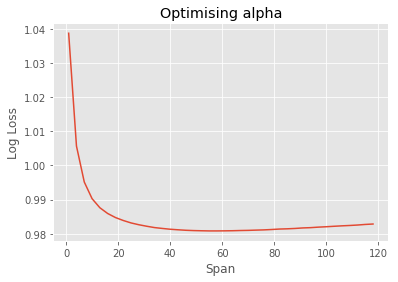

Our lowest log loss (0.980848) occurred at a span of 58


In [31]:
plt.style.use('ggplot')
plt.plot(list(range(1, 120, 3)), (pd.Series(cv_scores)*-1)) # Plot our results

plt.title("Optimising alpha")
plt.xlabel("Span")
plt.ylabel("Log Loss")
plt.show()

print("Our lowest log loss ({:2f}) occurred at a span of {}".format(best_score, best_span))

## Create feature DF

In [34]:
# Create feature DataFrames
features_all_games = create_all_games_features(all_games)

/Users/TheShit/btfair-au/code/nbs/data_preparation_functions.py:419: RuntimeWarning: invalid value encountered in double_scalars
  .pipe(lambda df: (df.eloAgainst * df[goalsForOrAgainstCol]).sum() / df.eloAgainst.sum()))


In [35]:
features_all_games.head(3)

,Date,awayWin,awayWinPc38,awayWinPc5,eloAgainst,eloFor,gameId,gameIdHistoric,goalsAgainst,goalsFor,homeGame,homeWin,homeWinPc38,homeWinPc5,season,team,wtEloGoalsFor,wtEloGoalsAgainst
0,2001-08-18,1,NaN,NaN,1500.0,1500.0,-1,1,2.0,1.0,1,0,NaN,NaN,20012002,Charlton,NaN,NaN
1,2001-08-18,1,NaN,NaN,1500.0,1500.0,-1,1,1.0,2.0,0,0,NaN,NaN,20012002,Everton,NaN,NaN
2,2001-08-18,0,NaN,NaN,1500.0,1500.0,-1,2,1.0,2.0,1,1,NaN,NaN,20012002,Derby,NaN,NaN


In [36]:
# Create feature stats df
features_stats = create_stats_features_ema(stats, span=best_span)
features_stats.tail(3)

,gameId,team,homeGame,cornersAgainst,cornersFor,freesAgainst,freesFor,goalsAgainst,goalsFor,halfTimeGoalsAgainst,halfTimeGoalsFor,redsAgainst,redsFor,shotsAgainst,shotsFor,shotsOnTargetAgainst,shotsOnTargetFor,yellowsAgainst,yellowsFor
9905,4953,Fulham,1,6.017997,5.035349,10.254851,9.967534,2.127914,1.096746,0.631174,0.370291,0.033991,0.043641,16.472239,11.701795,7.200210,4.693457,1.308366,1.387940
9906,4954,Man United,1,4.455402,5.477227,11.597336,10.926662,0.840645,1.587276,0.422938,0.730980,0.043997,0.028437,10.858229,13.044209,3.559643,4.641517,1.740926,1.716478
9907,4954,Tottenham,0,3.885923,6.384787,10.805772,10.172431,0.950823,2.097408,0.437118,0.801856,0.026100,0.026613,9.931247,16.487736,3.361266,6.141285,1.929722,1.372211


In [37]:
# Create feature_odds df
features_odds = create_betting_features_ema(betting, span=10)
features_odds.tail(3)

,gameId,team,avAsianHandicapOddsAgainst,avAsianHandicapOddsFor,avgreaterthan2.5,avlessthan2.5,sizeOfHandicap
9905,4953,Fulham,1.884552,1.985978,1.756776,2.128261,0.502253
9906,4954,Man United,1.871586,2.031787,1.900655,1.963478,-0.942445
9907,4954,Tottenham,1.947833,1.919607,1.629089,2.383593,-1.235630


In [38]:
# Create feature market values df
features_market_values = create_market_values_features(df) # This creates a df with one game per row
features_market_values.head(3)

,gameId,Year,HomeTeam,AwayTeam,defMktValH,attMktValH,gkMktValH,totalMktValH,midMktValH,defMktValA,attMktValA,gkMktValA,totalMktValA,midMktValA,attMktH%,attMktA%,midMktH%,midMktA%,defMktH%,defMktA%,gkMktH%,gkMktA%,totalMktH%,totalMktA%
0,1,2005,West Ham,Blackburn,16.90,18.50,6.40,46.40,4.60,27.25,13.00,3.25,70.70,27.20,2.252911,1.583126,0.588168,3.477861,2.486940,4.010007,4.524247,2.297469,1.913986,2.916354
1,2,2005,Aston Villa,Bolton,27.63,31.85,7.60,105.83,38.75,9.60,24.55,8.50,72.40,29.75,3.878659,2.989673,4.954673,3.803910,4.065926,1.412700,5.372543,6.008766,4.365456,2.986478
2,3,2005,Everton,Man United,44.35,31.38,8.55,109.78,25.50,82.63,114.60,9.25,288.48,82.00,3.821423,13.955867,3.260494,10.484727,6.526378,12.159517,6.044111,6.538951,4.528392,11.899714


In [39]:
all_games_cols = ['Date', 'gameId', 'team', 'season', 'homeGame', 'homeWinPc38', 'homeWinPc5', 'awayWinPc38', 'awayWinPc5', 'eloFor', 'eloAgainst', 'wtEloGoalsFor', 'wtEloGoalsAgainst']

# Join the features together
features_multi_line = (features_all_games[all_games_cols]
                                         .pipe(pd.merge, features_stats.drop(columns='homeGame'), on=['gameId', 'team'])
                                         .pipe(pd.merge, features_odds, on=['gameId', 'team']))

In [40]:
# Put each instance on an individual row
features_with_na = put_features_on_one_line(features_multi_line)

market_val_feature_names = ['attMktH%', 'attMktA%', 'midMktH%', 'midMktA%', 'defMktH%', 'defMktA%', 'gkMktH%', 'gkMktA%', 'totalMktH%', 'totalMktA%']

# Merge our team values dataframe to features and result from df
features_with_na = (features_with_na.pipe(pd.merge, (features_market_values[market_val_feature_names + ['gameId']])
                                                      .rename({col: 'f_' + col for col in market_val_feature_names}), on='gameId')
                            .pipe(pd.merge, df[['HomeTeam', 'AwayTeam', 'gameId', 'result', 'B365A', 'B365D', 'B365H']], on=['HomeTeam', 'AwayTeam', 'gameId']))

# Drop NAs from calculating the rolling averages - don't drop Win Pc 38 and Win Pc 5 columns
features = features_with_na.dropna(subset=features_with_na.drop(columns=[col for col in features_with_na.columns if 'WinPc' in col]).columns)

# Fill NAs for the Win Pc columns
features = features.fillna(features.mean())

In [41]:
features.head(3)

,Date,gameId,HomeTeam,season,homeGame,f_homeWinPc38Home,f_homeWinPc5Home,f_awayWinPc38Home,f_awayWinPc5Home,f_eloForHome,f_eloAgainstHome,f_wtEloGoalsForHome,f_wtEloGoalsAgainstHome,f_cornersAgainstHome,f_cornersForHome,f_freesAgainstHome,f_freesForHome,f_goalsAgainstHome,f_goalsForHome,f_halfTimeGoalsAgainstHome,f_halfTimeGoalsForHome,f_redsAgainstHome,f_redsForHome,f_shotsAgainstHome,f_shotsForHome,f_shotsOnTargetAgainstHome,f_shotsOnTargetForHome,f_yellowsAgainstHome,f_yellowsForHome,f_avAsianHandicapOddsAgainstHome,f_avAsianHandicapOddsForHome,f_avgreaterthan2.5Home,f_avlessthan2.5Home,f_sizeOfHandicapHome,AwayTeam,f_homeWinPc38Away,f_homeWinPc5Away,f_awayWinPc38Away,f_awayWinPc5Away,f_eloForAway,f_eloAgainstAway,f_wtEloGoalsForAway,f_wtEloGoalsAgainstAway,f_cornersAgainstAway,f_cornersForAway,f_freesAgainstAway,f_freesForAway,f_goalsAgainstAway,f_goalsForAway,f_halfTimeGoalsAgainstAway,f_halfTimeGoalsForAway,f_redsAgainstAway,f_redsForAway,f_shotsAgainstAway,f_shotsForAway,f_shotsOnTargetAgainstAway,f_shotsOnTargetForAway,f_yellowsAgainstAway,f_yellowsForAway,f_avAsianHandicapOddsAgainstAway,f_avAsianHandicapOddsForAway,f_avgreaterthan2.5Away,f_avlessthan2.5Away,f_sizeOfHandicapAway,attMktH%,attMktA%,midMktH%,midMktA%,defMktH%,defMktA%,gkMktH%,gkMktA%,totalMktH%,totalMktA%,result,B365A,B365D,B365H
20,2005-08-23,21,Birmingham,0506,1,0.394737,0.4,0.263158,0.2,1478.687038,1492.866048,1.061763,1.260223,4.982759,7.525862,12.000000,9.948276,1.017241,0.508621,0.508621,0.508621,0.000000,0.000000,11.948276,8.017241,6.491379,2.982759,1.000000,2.508621,1.9090,1.9455,2.0510,1.6735,-0.1375,Middlesbrough,0.394737,0.4,0.263158,0.2,1492.866048,1478.687038,1.12994,1.279873,2.543103,5.508621,13.543103,13.439655,1.017241,0.000000,0.000000,0.000000,0.0,0.491379,17.017241,8.068966,7.508621,2.508621,3.0,1.491379,1.9395,1.9095,2.0035,1.7155,0.3875,5.132983,5.260851,3.341048,4.289788,3.502318,4.168935,2.332815,3.216457,3.934396,4.522205,away,2.75,3.2,2.50
21,2005-08-23,22,Portsmouth,0506,1,0.447368,0.4,0.263158,0.4,1405.968416,1489.229314,1.147101,1.503051,2.508621,4.965517,21.982759,16.051724,2.000000,0.508621,1.000000,0.000000,0.000000,0.000000,8.456897,10.491379,3.965517,4.456897,3.017241,1.525862,1.8965,1.9690,2.0040,1.7005,0.2500,Aston Villa,0.447368,0.4,0.263158,0.4,1489.229314,1405.968416,1.17516,1.263229,9.525862,7.000000,14.474138,17.560345,1.491379,0.982759,0.982759,0.982759,0.0,0.000000,15.543103,3.000000,9.051724,2.508621,2.0,0.508621,1.8565,1.9770,1.8505,1.8485,0.7125,3.738614,3.878659,4.494368,4.954673,2.884262,4.065926,3.746642,5.372543,3.743410,4.365456,draw,2.75,3.2,2.50
22,2005-08-23,23,Sunderland,0506,1,0.236842,0.0,0.236842,0.4,1277.888970,1552.291880,0.650176,1.543716,5.000000,5.000000,12.422414,17.543103,1.982759,0.491379,1.000000,0.491379,0.491379,0.508621,14.508621,6.913793,5.017241,3.931034,1.017241,2.508621,1.8520,1.9915,1.8535,1.8500,0.7125,Man City,0.236842,0.0,0.236842,0.4,1552.291880,1277.888970,1.28875,1.287367,7.525862,3.508621,8.965517,12.491379,0.508621,1.017241,0.508621,0.508621,0.0,0.000000,10.965517,11.948276,2.491379,6.982759,3.0,1.491379,1.8150,2.0395,2.0060,1.7095,-0.2000,0.706318,3.750792,1.476812,1.070209,2.634096,4.455890,0.777605,4.913050,1.499427,3.151477,away,2.50,3.2,2.75
